In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ReactionDiffusion, HomogeneousReactionDiffusion
from lafomo.models import NeuralOperator, NeuralLFM
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import plot_spatiotemporal_data, tight_kwargs

params torch.Size([4000, 4])


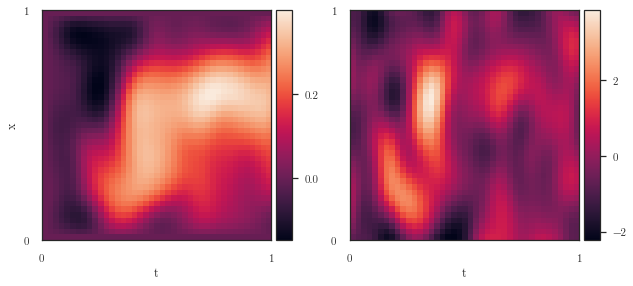

In [38]:
ntest = 50

dataset = ReactionDiffusion('../../../data', nn_format=True, max_n=4000, ntest=ntest)

i = 3
tx = dataset.data[i][0]
lf = dataset.data[i][1]
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [
        tx[:, :, 0].t(),
        lf[:, :, 0].t(),
    ],
    extent, nrows=1, ncols=2
)

batch_size = 150
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)

params torch.Size([50, 4])
params torch.Size([50, 4])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


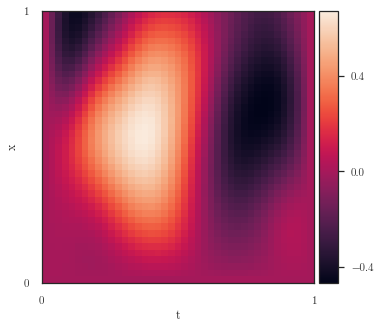

In [39]:
dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)

dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 2
learning_rate = 1e-3

modes = 8
width = 32
in_channels = 3


In [40]:
# model = NeuralOperator(block_dim, in_channels, modes, width)
r_dim = z_dim = 16
model = NeuralLFM(block_dim, in_channels,
                  modes, width, r_dim, z_dim)

print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

-1


In [41]:
trainer.train(1, num_context=30, num_target=11);

RuntimeError: shape '[150, -1]' is invalid for input of size 200

In [32]:
from torch.nn.functional import softplus
from lafomo.utilities.data import context_target_split as cts

def show_result(model, loader, weird=False):
    x, y, params = next(iter(loader))
    # num_outputs = params.shape[2]
    print(params.shape)
    x_context, y_context, _, _ = cts(x, y, x.shape[1], 0)
    p_y_pred, params_out = model(x_context, y_context, x, y)
    out = p_y_pred.mean
    print(out.shape)
    # out, params_out = model(x)

    num_t = x.shape[1]
    num_x = x.shape[2]
    print(num_t, num_x, x.shape)
    if not weird:
        plot_spatiotemporal_data(
            [
                out[0, ...].detach().view(num_t, num_x).t(),
                y[0, ...].view(num_t, num_x).t(),
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        )
    else:
        a = np.zeros((41, 41, 4))
        a[:, :, 0] = out[0, ..., 0].detach()
        a[:, :, 0] = (a[:, :, 0] - a[:, :, 0].min()) / (a[:, :, 0].max() - a[:, :, 0].min())
        a[:, :, 3] = out[0, ..., 1].detach()
        a[:, :, 3] = 1-(a[:, :, 3] - a[:, :, 3].min()) / (a[:, :, 3].max() - a[:, :, 3].min())
        # print(a)
        # a = out[0, ..., 0].detach()
        plt.imshow(a, origin='lower', extent=extent)
        # plt.imshow(out[0, ..., 1].detach(), origin='lower', extent=extent)
        plt.colorbar()
    out = out.squeeze()
    y_target = y.squeeze()
    print(params_out[0].detach(), params[0])
    print(F.mse_loss(out, y_target))
    # from lafomo.utilities.torch import smse, q2
    # print(y.shape, f_mean_test.shape)
    # print(smse(y_target, f_mean_test).shape)

torch.Size([50, 4])
torch.Size([50, 41, 41])
41 41 torch.Size([50, 41, 41, 3])
tensor([ 0.2757,  0.3373,  0.1948, -0.0183]) tensor([0.1000, 0.3000, 0.2650, 0.0010])
tensor(0.7065, grad_fn=<MseLossBackward>)


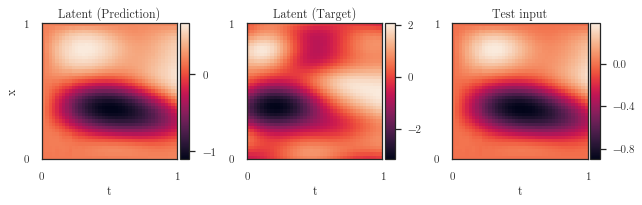

In [34]:
show_result(model, test_loader)

torch.Size([50, 4])
torch.Size([50, 41, 41])
41 41 torch.Size([50, 41, 41, 3])
tensor([ 0.1799,  0.2167,  0.1808, -0.0088]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.7519, grad_fn=<MseLossBackward>)
torch.Size([50, 4])
torch.Size([50, 81, 81])
81 81 torch.Size([50, 81, 81, 3])
tensor([0.7477, 0.6967, 0.6718, 0.0052]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.7448, grad_fn=<MseLossBackward>)


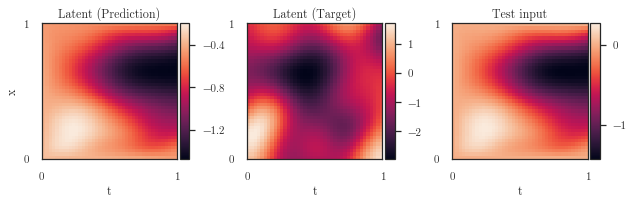

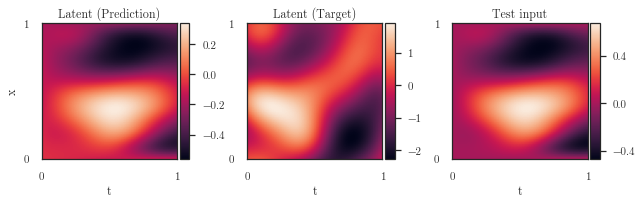

In [26]:
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


params torch.Size([1, 4])
torch.Size([8, 64, 3])
torch.Size([1, 4])
torch.Size([1, 8, 64])
8 64 torch.Size([1, 8, 64, 3])
tensor([0.0863, 0.1252, 0.0495, 0.0162]) tensor([-1., -1., -1., -1.])
tensor(0.3978, grad_fn=<MseLossBackward>)


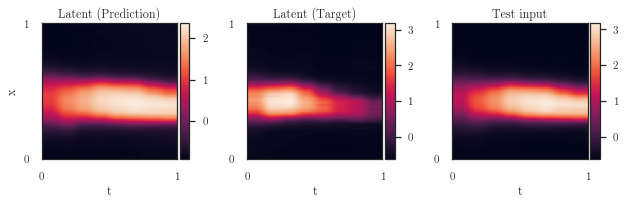

In [37]:
from lafomo.datasets import DrosophilaSpatialTranscriptomics

dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data', scale=True, nn_format=True)

dataset.train_data[0] = (
    dataset.train_data[0][0],#.permute(1, 0, 2),
    dataset.train_data[0][1],
    dataset.train_data[0][2]
)
print(dataset.train_data[0][0].shape)
dros_loader = DataLoader(dataset.train_data)

show_result(model, dros_loader)

In [ ]:
torch.save(model.state_dict(), './saved_model3205.pt')

In [ ]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)

x_sub, y_sub, params_sub = subsampled_loader.dataset[i]
x, y, params = high_res_loader.dataset[i]
out, _ = model(x.unsqueeze(0))
out_sub, _ = model(x_sub.unsqueeze(0))

num_t = x.shape[0]
num_x = x.shape[1]
num_t_sub = x_sub.shape[0]
num_x_sub = x_sub.shape[1]

plot_spatiotemporal_data(
    [
        x[..., 0].view(num_t, num_x).t(),
        out_sub[0, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[0, ..., 0].detach().view(num_t, num_x).t(),
        y_sub[..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[...,0].min(), x[...,0].max())] + [(out[0].min(), out[0].max())] * 3,
    titles=['Test input', 'Prediction', 'Super-resolution Prediction', 'Low-res Target']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
# plt.savefig('toy48.pdf', **tight_kwargs)

In [ ]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True, nn_format=True, ntest=0)
print(dataset.train_data[0][0].shape)

toy_loader = DataLoader(dataset.train_data)
show_result(model, toy_loader)
print(dataset[0][1].shape)
print(dataset.orig_data.shape)
plt.figure()
d = dataset.train_data[0][0][:, :, 0]
x = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True)
print(x[0][1].shape)
plt.imshow(x[0][1][0].view(41, 41).t(), origin='lower', extent=extent)
plt.figure()
plt.imshow(d.t(), origin='lower', extent=extent)